In [6]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

x = cdf.drop_duplicates(['hs_id', 'rf_id'])
x = x[x['max_iter'] < 49][['hs_id', 'rf_id', 'max_iter']]

with open('./exp2_n2.dag') as f:
    content = f.readlines()
    
keep = []

job_fmt = 'HS_{}_BATCH_0_START_{}'
for i, row in x.iterrows():
    hs_id = row['hs_id']
    rf_id = row['rf_id']
    jname = job_fmt.format(hs_id, rf_id)
    
    for line in content:
        if jname in line:
            keep.append(line)

with open('./exp2_n3.dag', 'w') as f:
    f.writelines(keep)
    
x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


hs_id rf_id  max_iter
0  InstanceBasedWCSelector_custom_0  3299        44

In [187]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

iter_max=50
task_col=None
cluster_col='BT_0.4 ID'

run_threshold=0
hs_params, benchmark_params, custom_params = 3, 4, 1
hs_job_count = hs_params*107
benchmark_job_count = benchmark_params*107
custom_job_count = custom_params*107

root_dir = '../../../aldd_results/params_results_exp_3\\'
hs_dir = glob.glob(root_dir+'sampled_hyparams/*/*/*/*/')
custom_dir = glob.glob(root_dir+'custom_cbws/*/*/*/*/')
benchmark_dir = glob.glob(root_dir+'benchmarks/*/*/*/*/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
all_96_hs, all_384_hs, all_1536_hs, all_df_hs, successful_jobs, failed_jobs = get_results(hs_dir, iter_max, task_col, cluster_col, run_threshold, False, False, True)

print('----------------------------------------------------------------------------')
print('HS Jobs:')
print('Total jobs: {}'.format(hs_job_count))
print('Failed jobs: {}'.format(len(failed_jobs)))
print('Successful jobs: {}'.format(len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
print('Total HS: {}'.format(hs_params))
print('Successful HS: {}'.format(len(hs_unique)))

----------------------------------------------------------------------------
HS Jobs:
Total jobs: 321
Failed jobs: 0
Successful jobs: 321
Total HS: 3
Successful HS: 3


In [188]:
all_96_bm, all_384_bm, all_1536_bm, all_df_bm, successful_jobs, failed_jobs = get_results(benchmark_dir, iter_max, task_col, cluster_col, run_threshold, False, False, True)

print('----------------------------------------------------------------------------')
print('Benchmark Jobs:')
print('Total jobs: {}'.format(benchmark_job_count))
print('Failed jobs: {}'.format(len(failed_jobs)))
print('Successful jobs: {}'.format(len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
print('Total HS: {}'.format(benchmark_params))
print('Successful HS: {}'.format(len(hs_unique)))

----------------------------------------------------------------------------
Benchmark Jobs:
Total jobs: 428
Failed jobs: 0
Successful jobs: 428
Total HS: 4
Successful HS: 4


In [87]:
all_96_cs, all_384_cs, all_1536_cs, all_df_cs, successful_jobs, failed_jobs = get_results(custom_dir, iter_max, task_col, cluster_col, run_threshold, False, False, True)

print('----------------------------------------------------------------------------')
print('Custom Jobs:')
print('Total jobs: {}'.format(custom_job_count))
print('Failed jobs: {}'.format(len(failed_jobs)))
print('Successful jobs: {}'.format(len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:3]) for x in successful_jobs])
print('Total HS: {}'.format(custom_params))
print('Successful HS: {}'.format(len(hs_unique)))

----------------------------------------------------------------------------
Custom Jobs:
Total jobs: 107
Failed jobs: 0
Successful jobs: 107
Total HS: 1
Successful HS: 1


In [89]:
recompute_task_info=Flase
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)

In [189]:
def helper_agg(col):
        if col.name  in ['rf_id', 'task_col']:
            return '-'
        elif col.name in ['hs_id', 'hs_group']:
            return col.unique()[0]
        else:
            if '_std' in col.name:
                return col.std()
            else:
                return col.mean()

des_cols = ['hs_id', 'max_iter', 'exploitation_hits', 'exploration_hits', 'total_hits',
            'total_unique_hits', 'total_batch_size', 'hs_group', 'task_col']
cdf = pd.concat([all_96_hs, all_96_bm, all_96_cs])

hit_limit_list = []
uhit_limit_list = []
cpd_count_list = []
for tcol in cdf['task_col'].tolist():
    a, b, c = task_hit_dict[tcol]
    hit_limit_list.append(a)
    uhit_limit_list.append(b)
    cpd_count_list.append(c)
    
cdf['hit_limit'] = hit_limit_list
cdf['unique_hit_limit'] = uhit_limit_list
cdf['cpd_count'] = cpd_count_list

sdf1 = cdf[cdf['iter_num']==9999][des_cols]
sdf1 = sdf1.groupby('hs_id').agg(helper_agg).sort_values('total_hits', ascending=False)
sorted_hid_list = sdf1.index.tolist()

sdf2 = cdf[cdf['iter_num']==9999][des_cols]
sdf2 = sdf2[[c for c in sdf2.columns if ('_hits' in c or 'hs_id' in c)]]
sdf2.columns = [c.replace('hits', 'std') for c in sdf2.columns]
sdf2 = sdf2.groupby('hs_id').agg(helper_agg).loc[sorted_hid_list]

sdf = pd.concat([sdf1, sdf2], axis=1)
sdf

max_iter  exploitation_hits  \
hs_id                                                          
MABSelector_exploitive                 49         604.383178   
MABSelector_2                          49         570.542056   
ClusterBasedWCSelector_341             49         127.196262   
ClusterBasedWCSelector_609             49           0.000000   
ClusterBasedWCSelector_custom_1        49         217.672897   
ClusterBasedWCSelector_55              49           0.000000   
ClusterBasedRandom                     49           0.000000   
InstanceBasedRandom                    49           0.000000   

                                 exploration_hits  total_hits  \
hs_id                                                           
MABSelector_exploitive                   0.000000  604.383178   
MABSelector_2                            0.000000  570.542056   
ClusterBasedWCSelector_341             421.616822  548.813084   
ClusterBasedWCSelector_609             491.401869  491.401869   
ClusterBasedWCSelector_custom_1        261.794393  479.467290   
ClusterBasedWCSelector_55              429.710280  429.710280   
ClusterBasedRandom                      89.252336   89.252336   
InstanceBasedRandom                     70.121495   70.121495   

                                 total_unique_hits  total_batch_size  \
hs_id                                                                  
MABSelector_exploitive                  321.757009            4800.0   
MABSelector_2                           289.644860            4800.0   
ClusterBasedWCSelector_341              326.635514            4800.0   
ClusterBasedWCSelector_609              355.532710            4800.0   
ClusterBasedWCSelector_custom_1         327.177570            4800.0   
ClusterBasedWCSelector_55               358.392523            4800.0   
ClusterBasedRandom                       88.271028            4800.0   
InstanceBasedRandom                      68.467290            4800.0   

                                         hs_group task_col  exploitation_std  \
hs_id                                                                          
MABSelector_exploitive                 benchmarks        -        831.452192   
MABSelector_2                          benchmarks        -        730.673820   
ClusterBasedWCSelector_341       sampled_hyparams        -        372.480529   
ClusterBasedWCSelector_609       sampled_hyparams        -          0.000000   
ClusterBasedWCSelector_custom_1       custom_cbws        -        243.132729   
ClusterBasedWCSelector_55        sampled_hyparams        -          0.000000   
ClusterBasedRandom                     benchmarks        -          0.000000   
InstanceBasedRandom                    benchmarks        -          0.000000   

                                 exploration_std   total_std  total_unique_std  
hs_id                                                                           
MABSelector_exploitive                  0.000000  831.452192        373.101378  
MABSelector_2                           0.000000  730.673820        302.979302  
ClusterBasedWCSelector_341            443.376871  705.645137        400.628172  
ClusterBasedWCSelector_609            574.289008  574.289008        458.020460  
ClusterBasedWCSelector_custom_1       376.394307  611.878569        427.602086  
ClusterBasedWCSelector_55             520.002431  520.002431        480.938465  
ClusterBasedRandom                    163.580751  163.580751        161.697048  
InstanceBasedRandom                   141.565087  141.565087        136.624973

---
## Plot per Task Performance

## Total Hits

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


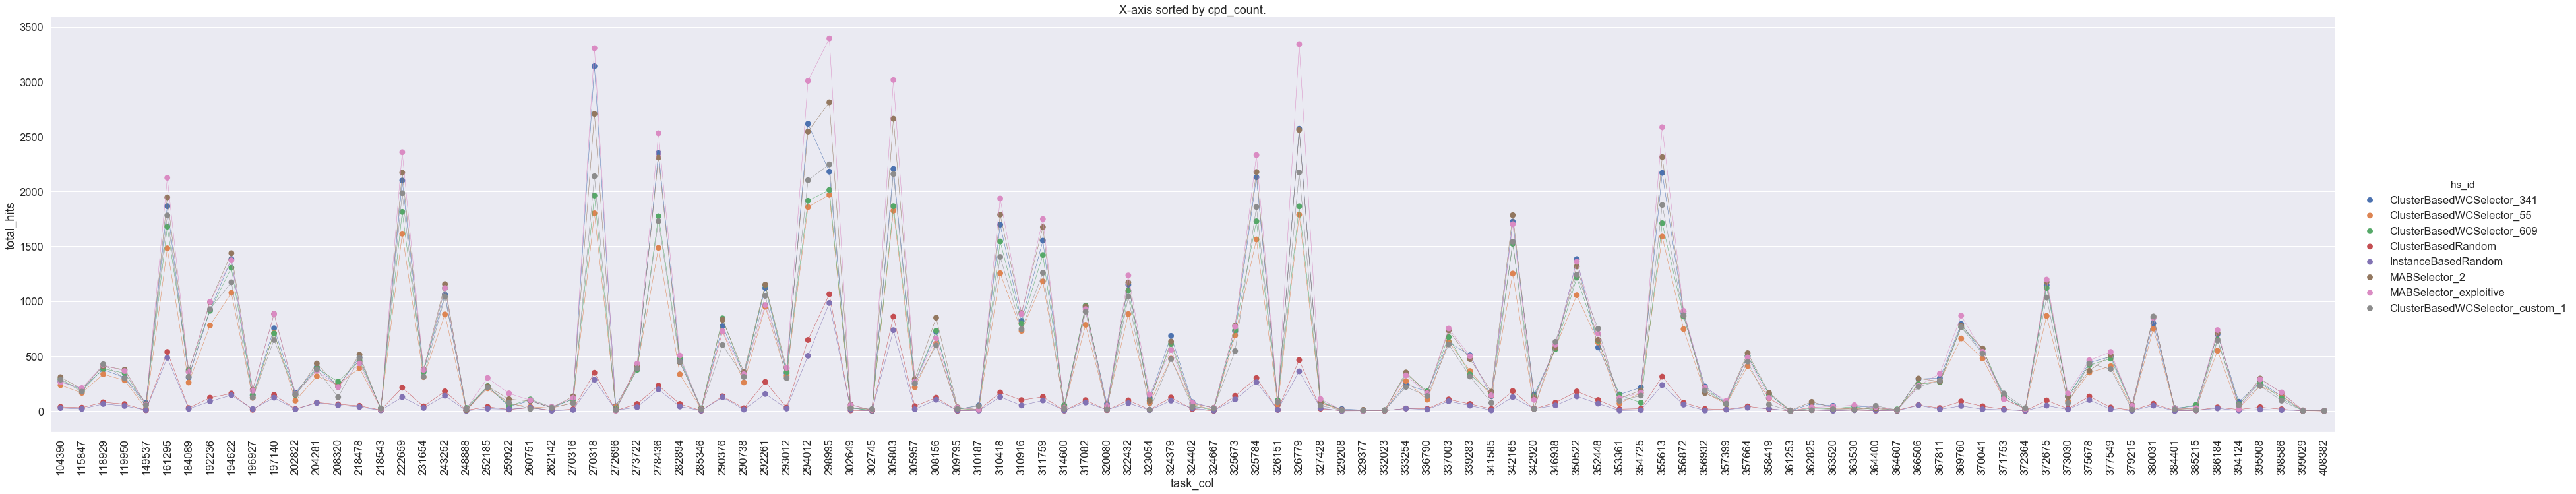

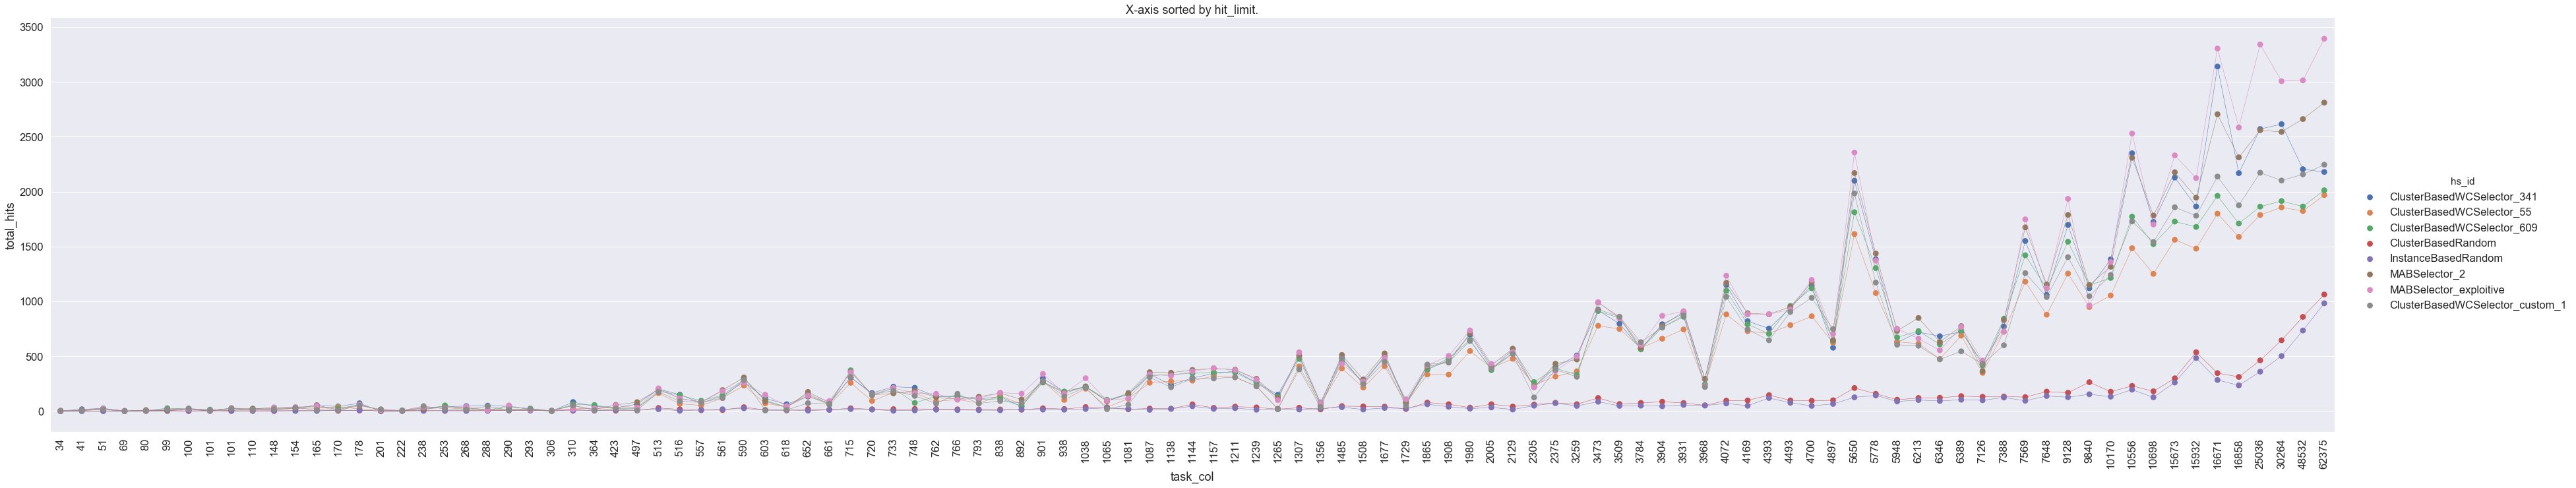

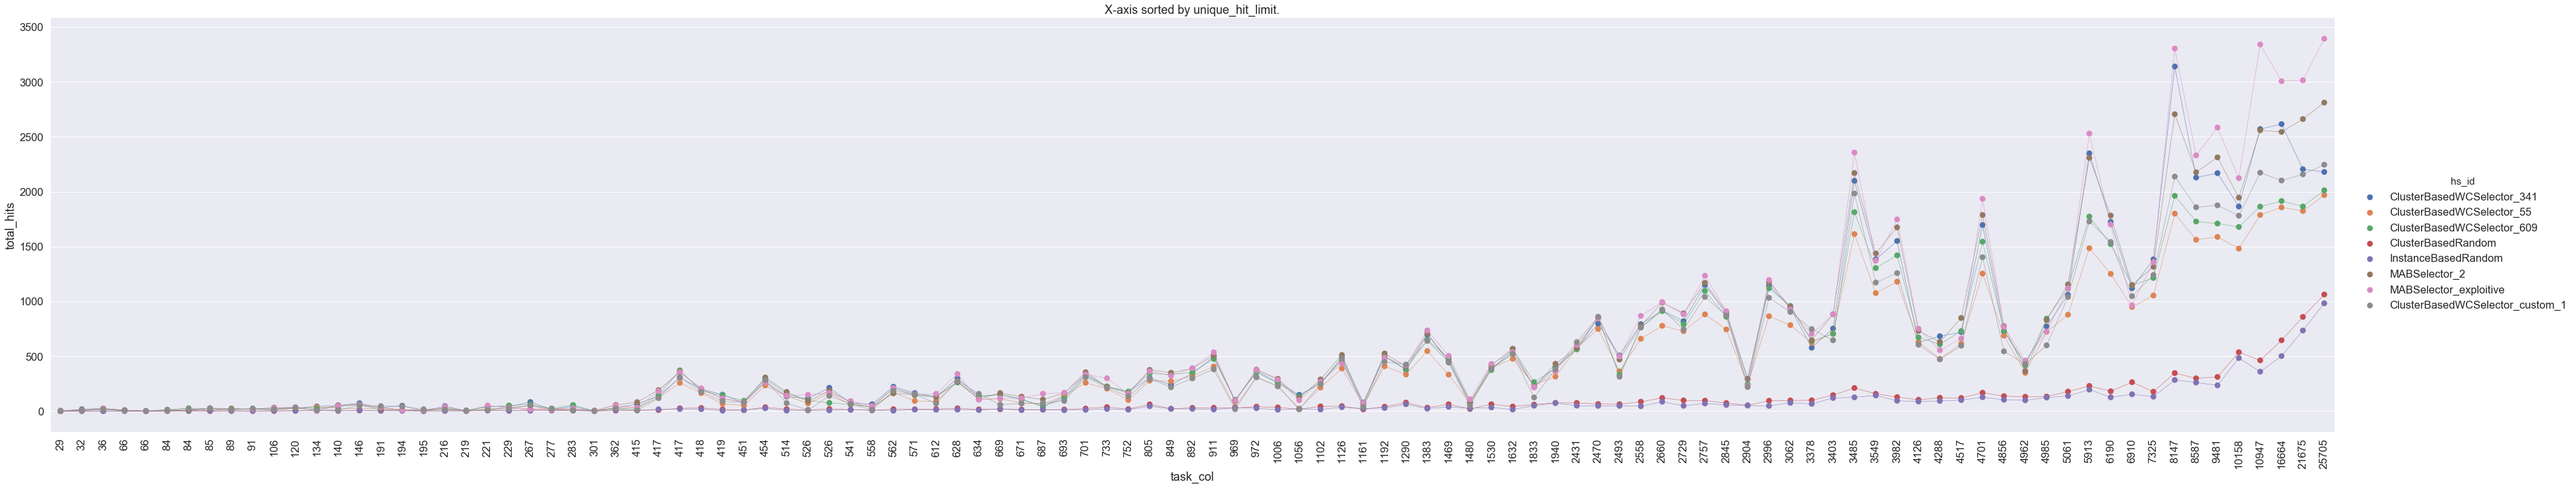

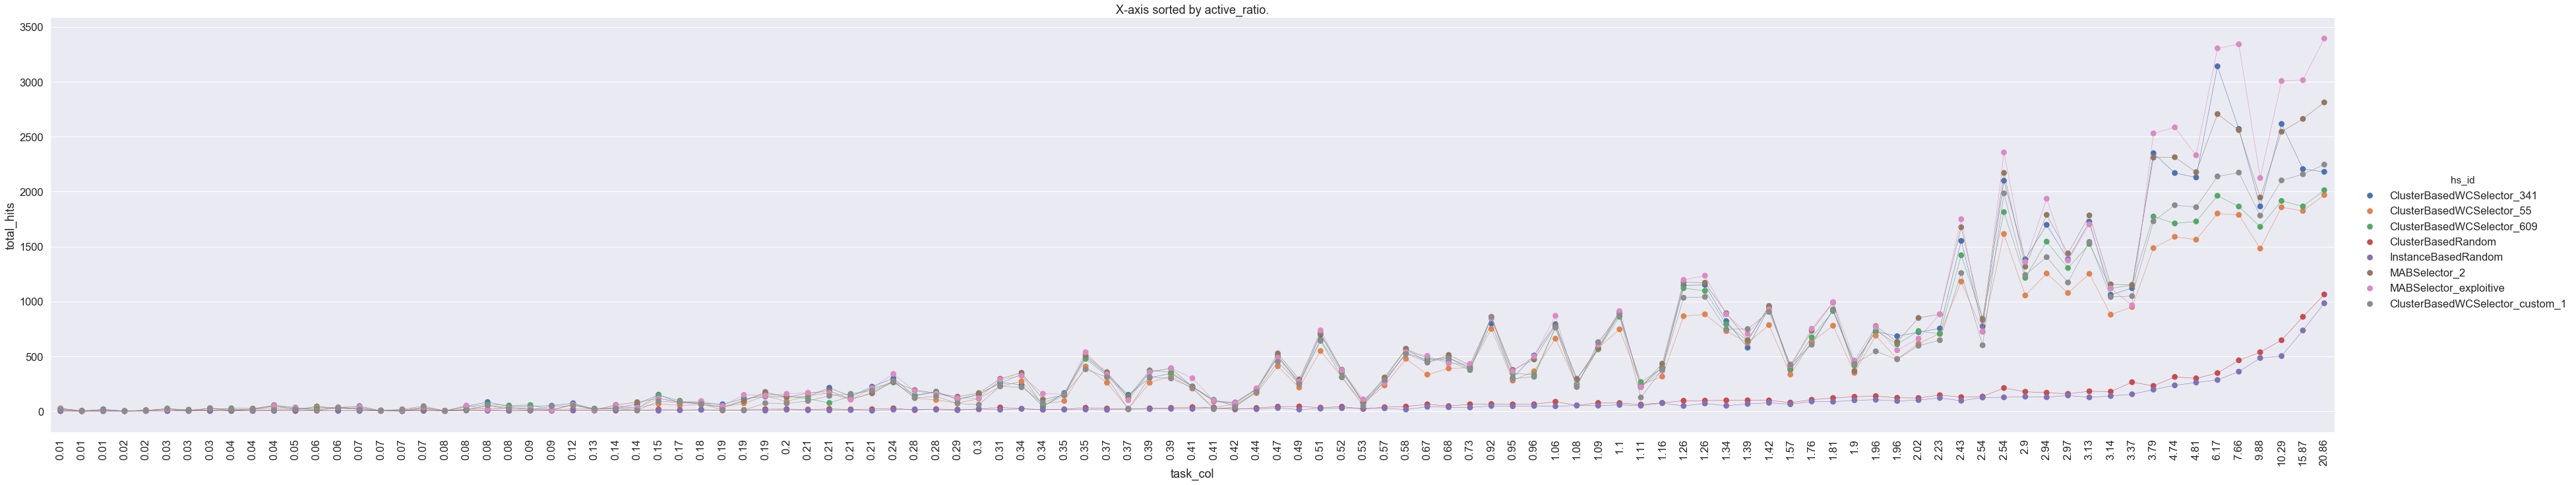

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

task_dfs = cdf[cdf['iter_num']==9999][des_cols + ['hit_limit', 'unique_hit_limit', 'cpd_count']]
task_dfs['total_hits_log'] = np.log(task_dfs['total_hits'].values)

task_info = task_dfs[['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count']].drop_duplicates()
task_info['active_ratio'] = np.around(100.0 * task_info['hit_limit'] / task_info['cpd_count'], decimals=2)
task_info['hit_limit'] = task_info['hit_limit'].astype(int)

figsize=(50, 16)

for col in ['cpd_count', 'hit_limit', 'unique_hit_limit', 'active_ratio']:
    task_order = task_info.sort_values(col)['task_col'].tolist()
    task_values = task_info.sort_values(col)[col].values
    g = sns.catplot(x="task_col", y="total_hits", hue="hs_id", kind="point", data=task_dfs,
                    order=task_order, scatter_kws={"s": 1},
                    linestyles='-', height=10, aspect=5.0)
    g.set_xticklabels(rotation=90)
    lw = g.ax.lines[0].get_linewidth() # lw of first line
    plt.setp(g.ax.lines,linewidth=0.5) 
    g.set(xticklabels=task_values)
    plt.title('X-axis sorted by {}.'.format(col))

## Total Hits Log-scale

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


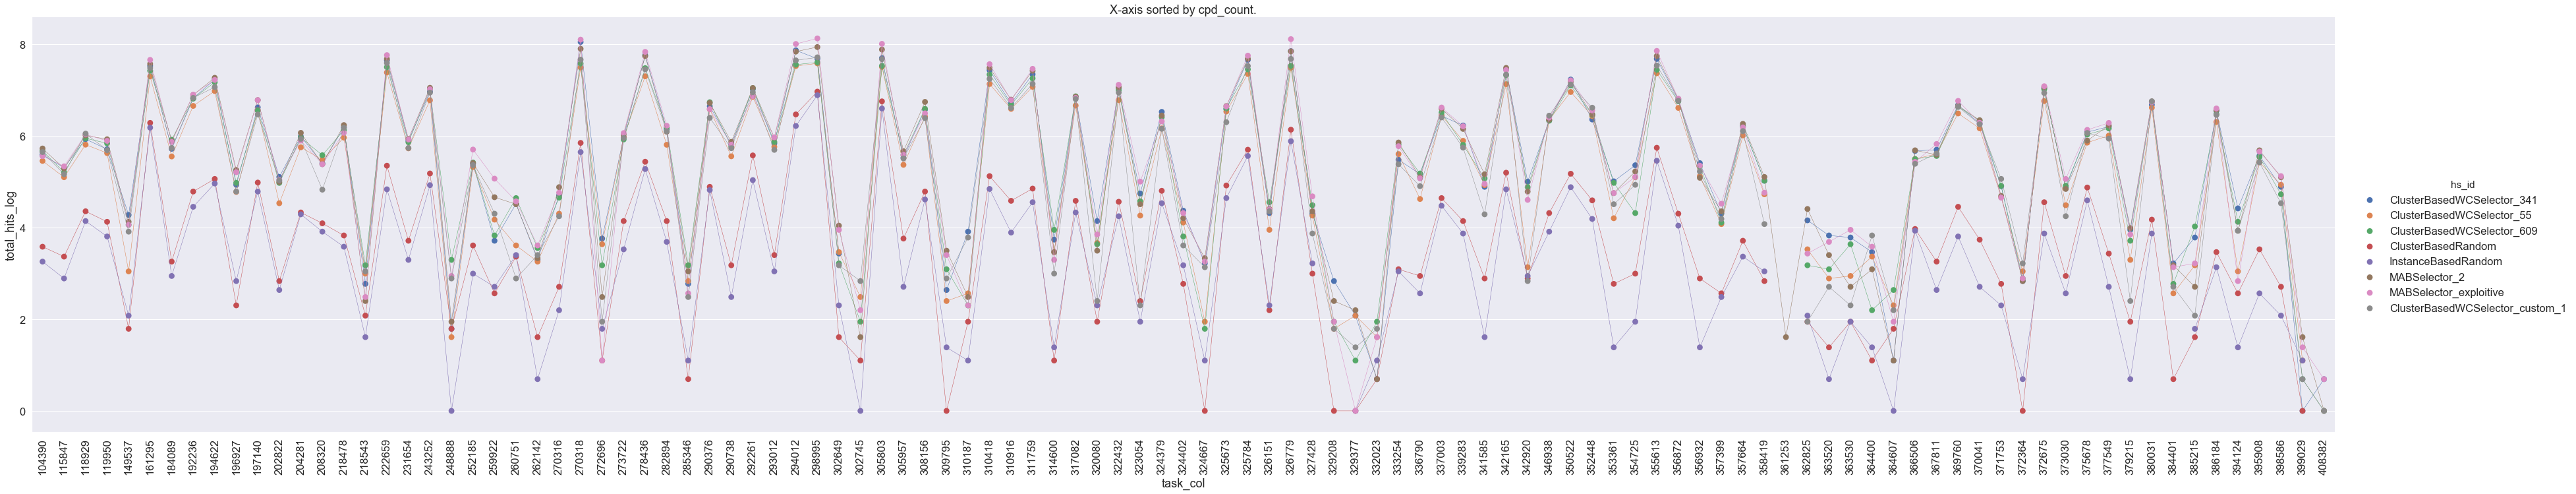

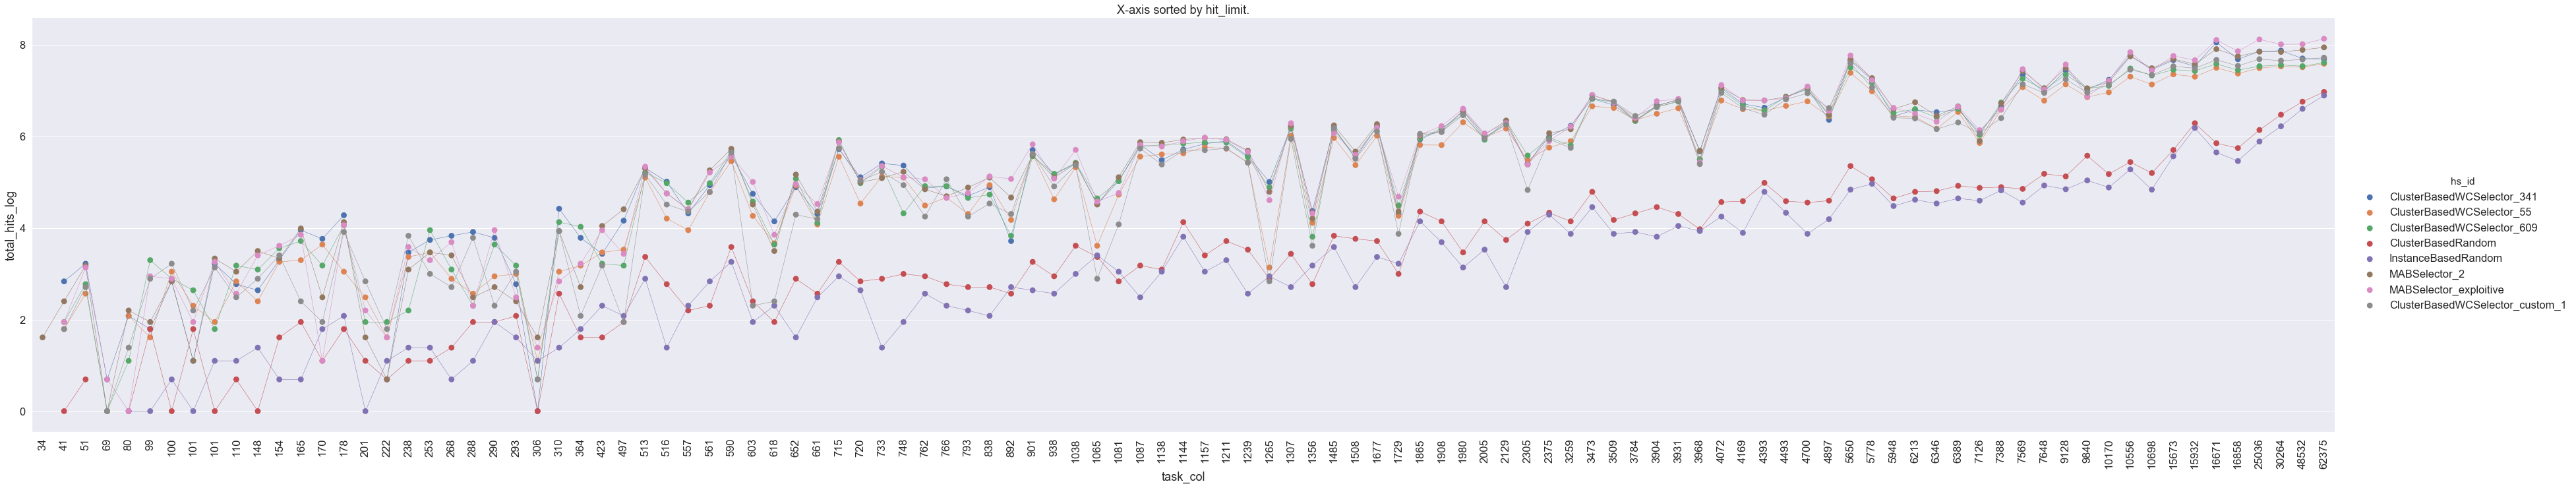

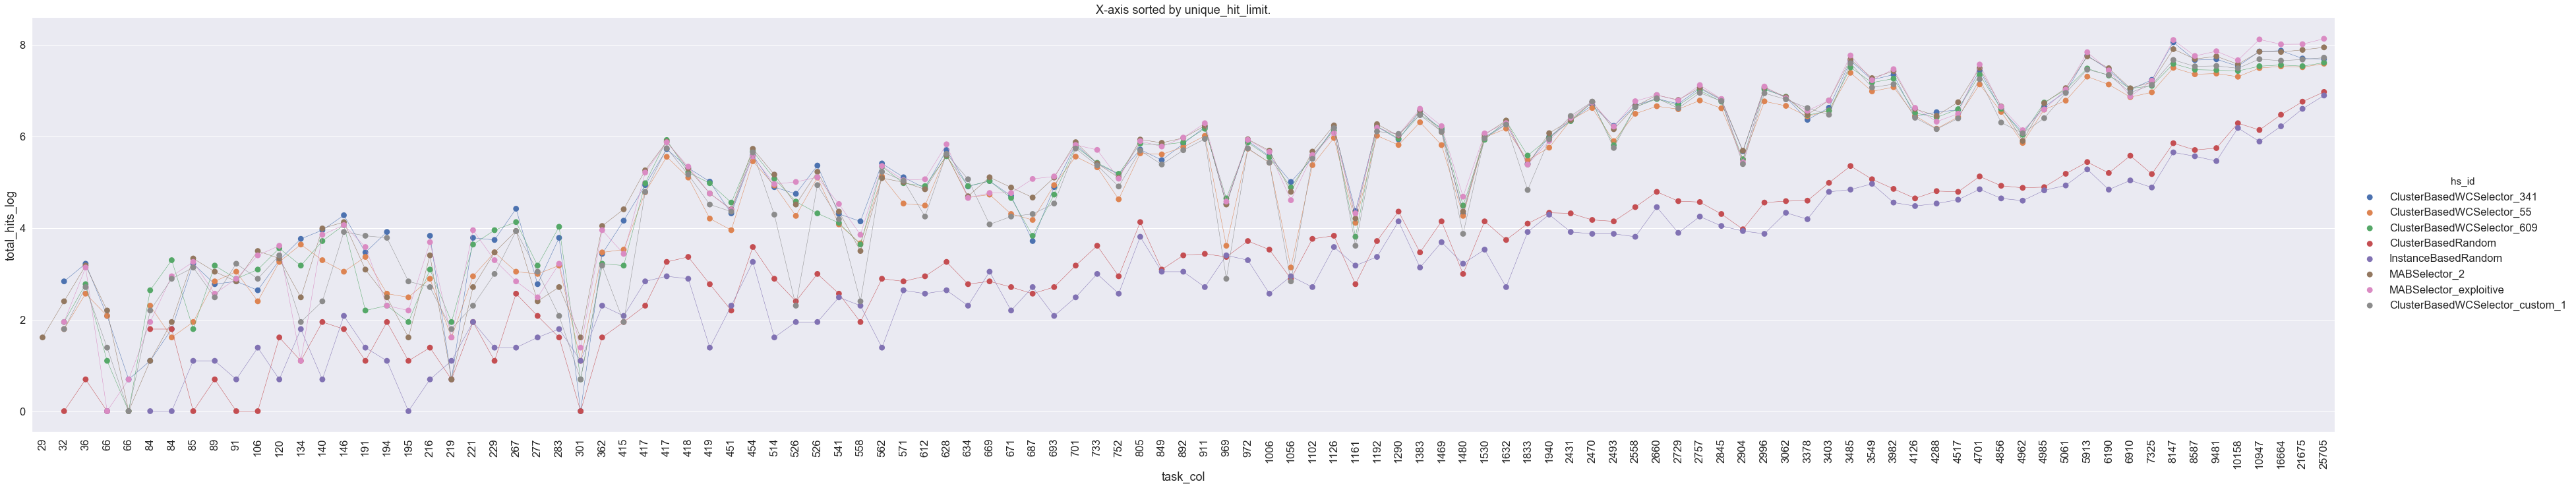

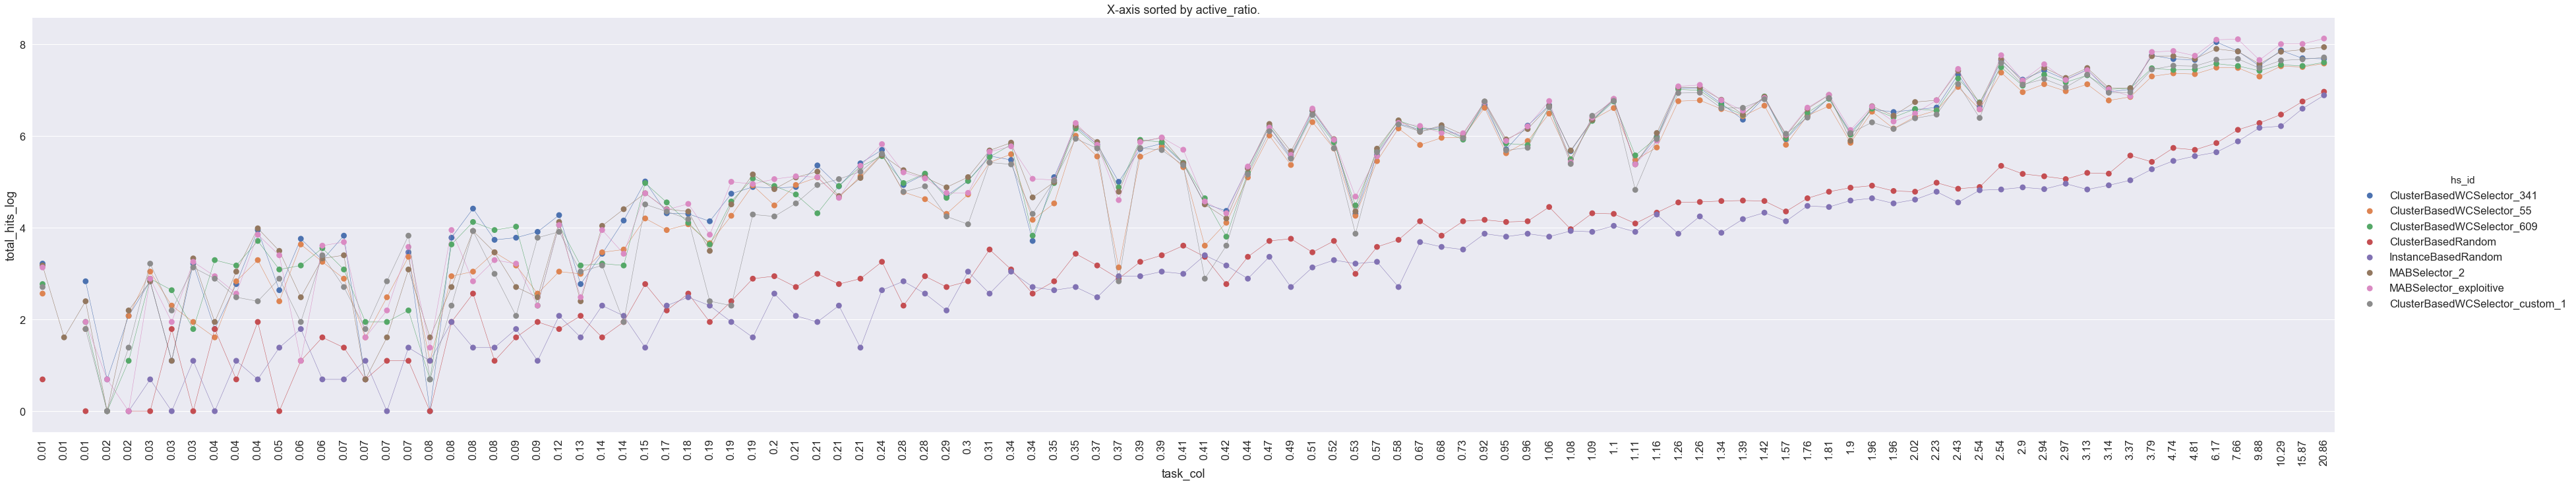

In [177]:
figsize=(50, 16)

for col in ['cpd_count', 'hit_limit', 'unique_hit_limit', 'active_ratio']:
    task_order = task_info.sort_values(col)['task_col'].tolist()
    task_values = task_info.sort_values(col)[col].values
    task_dfs['total_hits_log'] = np.log(task_dfs['total_hits'].values)
    g = sns.catplot(x="task_col", y="total_hits_log", hue="hs_id", kind="point", data=task_dfs,
                    order=task_order, scatter_kws={"s": 1},
                    linestyles='-', height=10, aspect=5.0)
    g.set_xticklabels(rotation=90)
    lw = g.ax.lines[0].get_linewidth() # lw of first line
    plt.setp(g.ax.lines,linewidth=0.5) 
    g.set(xticklabels=task_values)
    plt.title('X-axis sorted by {}.'.format(col))

## Total Unique Hits

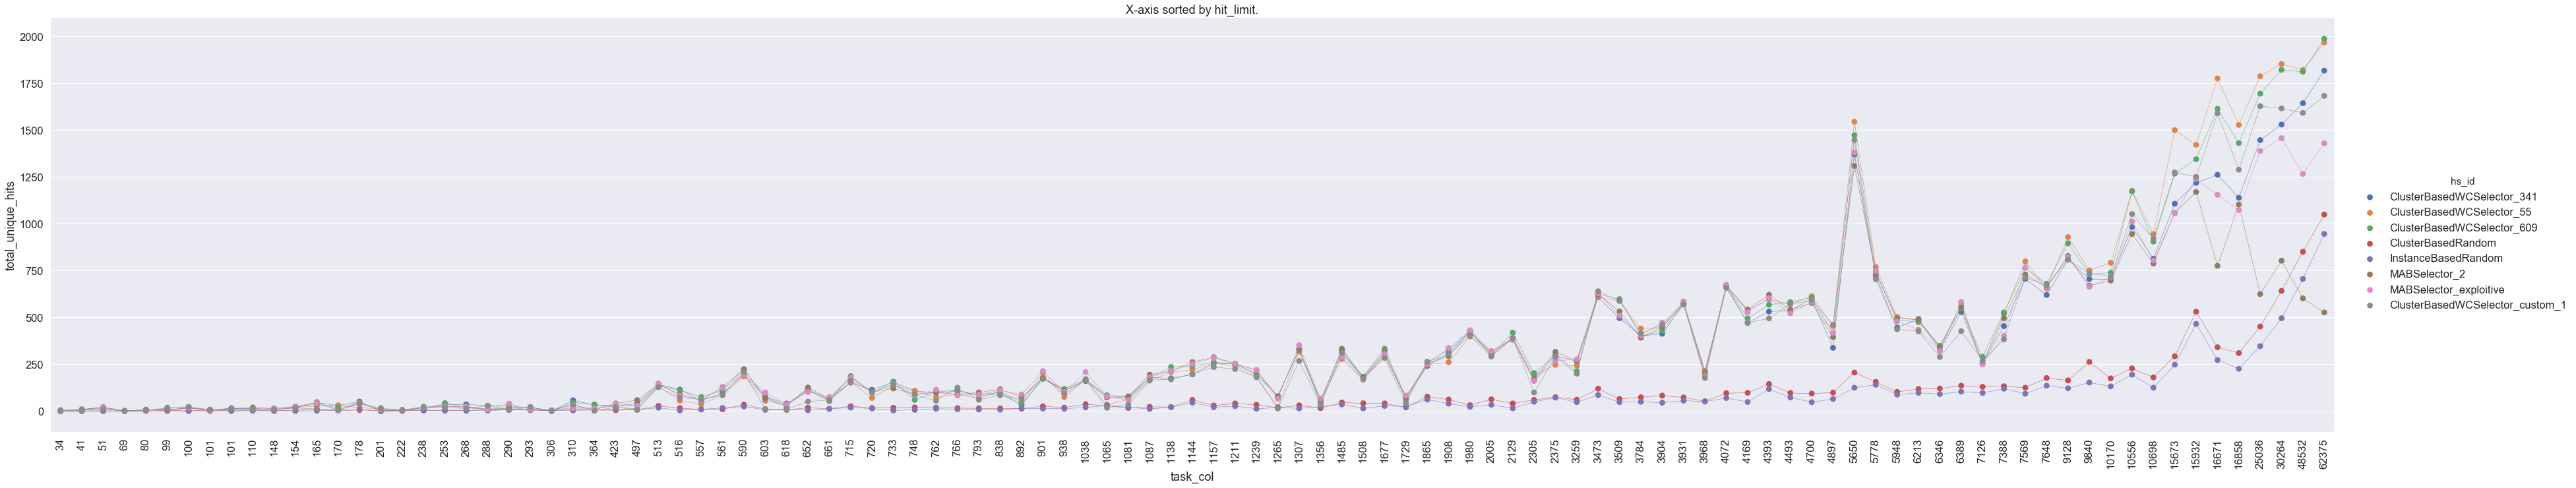

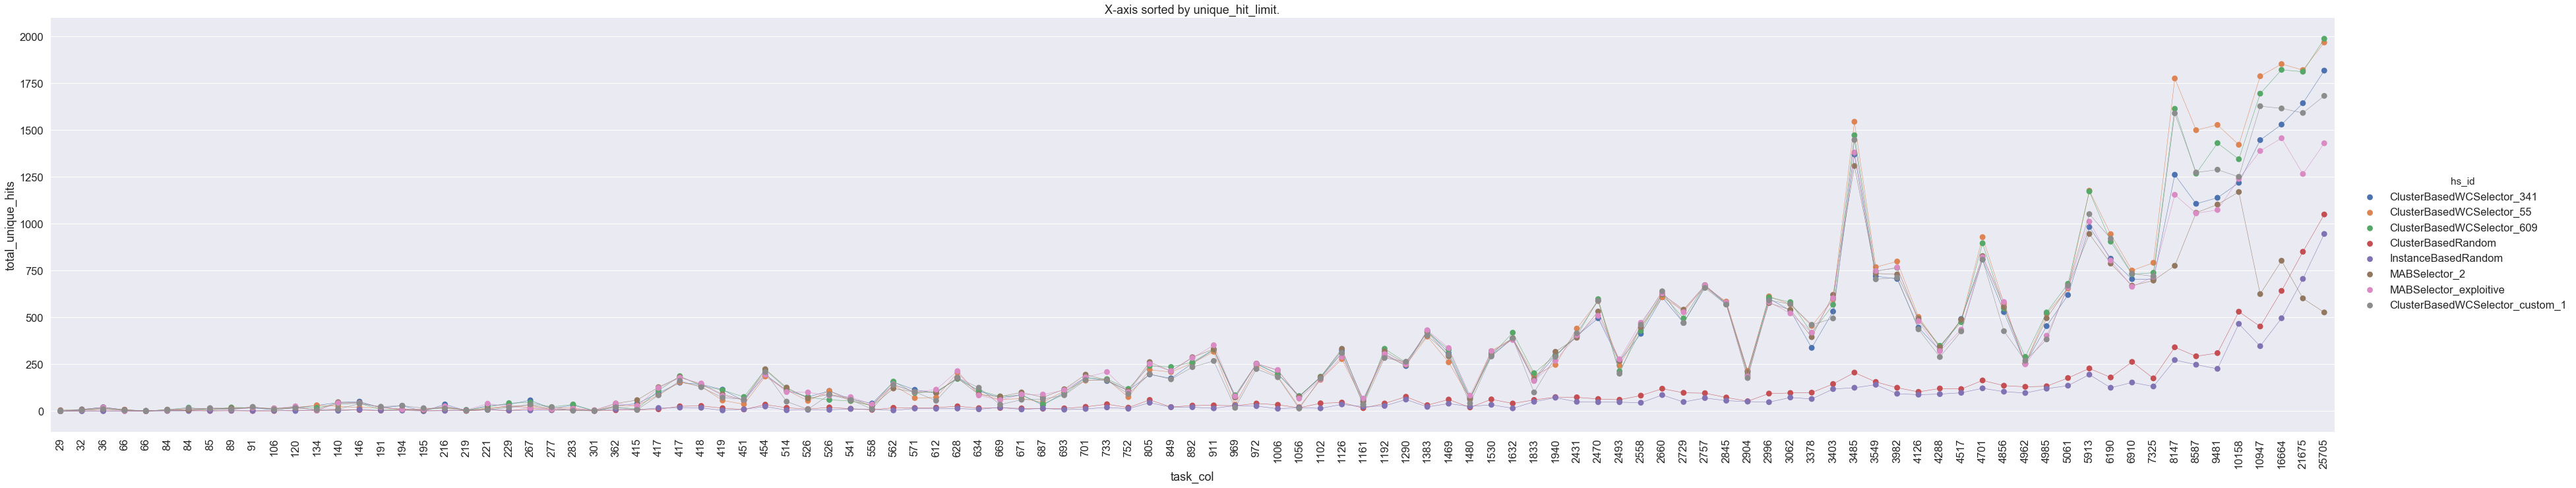

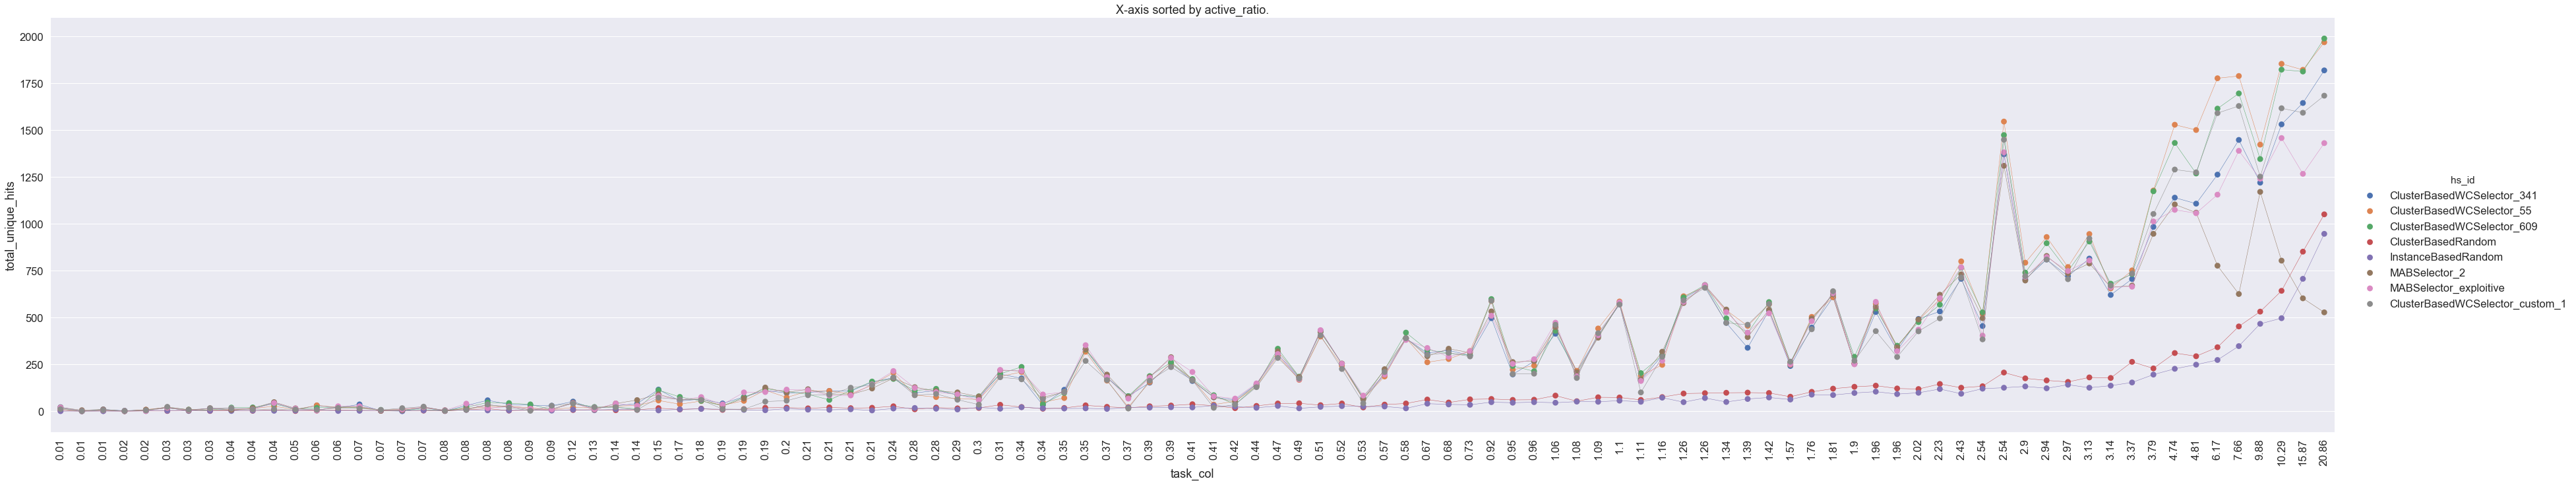

In [200]:
figsize=(50, 16)

for col in ['hit_limit', 'unique_hit_limit', 'active_ratio']:
    task_order = task_info.sort_values(col)['task_col'].tolist()
    task_values = task_info.sort_values(col)[col].values
    g = sns.catplot(x="task_col", y="total_unique_hits", hue="hs_id", kind="point", data=task_dfs,
                    order=task_order, scatter_kws={"s": 1},
                    linestyles='-', height=10, aspect=5.0)
    g.set_xticklabels(rotation=90)
    lw = g.ax.lines[0].get_linewidth() # lw of first line
    plt.setp(g.ax.lines,linewidth=0.5) 
    g.set(xticklabels=task_values)
    plt.title('X-axis sorted by {}.'.format(col))

---

# Win Comparisons

In [203]:
def get_win_mat(task_dfs, metric):
    hs_ids = task_dfs['hs_id'].unique()
    task_cols = task_dfs['task_col'].unique()
    comp_mat = np.zeros((len(hs_ids), len(hs_ids), len(task_cols)))

    for task_i in range(len(task_cols)):
        curr_task_df = task_dfs[task_dfs['task_col'] == task_cols[task_i]]
        curr_task_df.index = curr_task_df['hs_id']
        for hs_i in range(len(hs_ids)):
            value_i = curr_task_df.loc[hs_ids[hs_i], metric]
            for hs_j in range(len(hs_ids)):
                value_j = curr_task_df.loc[hs_ids[hs_j], metric]

                if value_i > (1.1*value_j):
                    comp_mat[hs_i, hs_j, task_i] = 1
    
    return comp_mat

comp_mat = get_win_mat(task_dfs, metric='total_hits')
toplist= []
for task_i in range(len(task_cols)):
    winsum = comp_mat[:,:,task_i].sum(axis=1)
    if np.sum(winsum) > 0:
        toplist.append(hs_ids[np.argsort(winsum)[::-1]][0])

u, c = np.unique(toplist, return_counts=True)
u, c, np.sum(c)

(array(['ClusterBasedWCSelector_341', 'ClusterBasedWCSelector_609',
        'ClusterBasedWCSelector_custom_1', 'MABSelector_2',
        'MABSelector_exploitive'], dtype='<U31'),
 array([12, 12, 11, 22, 50], dtype=int64),
 107)

In [204]:
comp_mat = get_win_mat(task_dfs, metric='total_unique_hits')
                
toplist= []
for task_i in range(len(task_cols)):
    winsum = comp_mat[:,:,task_i].sum(axis=1)
    if np.sum(winsum) > 0:
        toplist.append(hs_ids[np.argsort(winsum)[::-1]][0])
    
u, c = np.unique(toplist, return_counts=True)
u, c, np.sum(c)

(array(['ClusterBasedWCSelector_341', 'ClusterBasedWCSelector_55',
        'ClusterBasedWCSelector_609', 'ClusterBasedWCSelector_custom_1',
        'MABSelector_2', 'MABSelector_exploitive'], dtype='<U31'),
 array([ 7, 13, 25, 19, 18, 25], dtype=int64),
 107)